In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random
import time
import pandas as pd
import math
import csv
import os

t0=time.time()
###########################################################
###########################################################

# Esta celda define funciones y carga librerías.
# También sirve para levantar el nombre de los archivos, por lo que cada vez que armes
# nuevos archivos tenés que volver a correrla para volver a registrar los nuevos nombres

############################################################
############################################################

def scan(cant,lista):
    i=0
    for x in lista:
        print(x)
        i+=1
        if i>cant:
            break
            
def Tiempo():
    t1=time.time()
    print("Esto tardó {} segundos".format(t1-t0))


def ldata(archive):
        f = open(archive)
        data = []
        for line in f:
            col = line.split("\t")
            col = [x.strip() for x in col]
            data.append(col)
        return data 
    
# Vamos a leer los archivos con esta celda. Al darle la dirección de la carpeta Datos, lo que estoy sacando
# son los nombres de todos los archivos en esa carpeta.
#--------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./Datos Corte")]

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[0] es el nombre de la carpeta

for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Datos
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]

#----------------------------------------------------------------------------

Tiempo()

Esto tardó 0.0010023117065429688 segundos


In [9]:
t0=time.time()

# En esta celda voy a levantar los datos de opiniones y buscar encontrar el valor de error que
# me permita definir un criterio de corte para mi función principal
#-------------------------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./Datos Corte")]

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[0] es el nombre de la carpeta

for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Datos Corte
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]

#----------------------------------------------------------------------------

# Tengo dos tipos de archivos. Los de datos de opiniones tienen el siguiente formato:
# Datos_Evolucion_Opinion_N=$_T=$_K=$
# Los de datos de error cuadrático tienen el formato: Datos_Variacion_Promedio_N=$_T=$_K=$
# Armemos dos listas, una con los nombres de las opiniones y otra con los nombres de los errores.
# En ambas listas el primer elemento va a ser la carpeta en la que se encuentran los datos.
# En esta celda voy a construir la lista de Nombres de Opiniones


Nombres_Opiniones = [Archivos_Datos[0]]
for nombre in Archivos_Datos[1:len(Archivos_Datos)]:
    if nombre.split("_")[1] == "Evolucion":
        Nombres_Opiniones.append(nombre)



# Bien, las listas de nombres de archivos ya se arman correctamente

#-----------------------------------------------------------------------------

# Como el número de agentes de cada batch de datos no tiene porqué ser siempre el 
# mismo, me gustaría saber cuál es el máximo y mínimo número de agentes. Por razones.

Nmin = int(Nombres_Opiniones[1].split("_")[3].split("=")[1])
Nmax = int(Nombres_Opiniones[1].split("_")[3].split("=")[1])

# Defino un Nmin y Nmax inicial cualquiera, pero que esté dentro del conjunto total

for nombre in Nombres_Opiniones[1:len(Nombres_Opiniones)]:
    N = int(nombre.split("_")[3].split("=")[1])
    Nmin = min(N,Nmin)
    Nmax = max(N,Nmax)

# Bien, esto ya me obtiene los valores de Nmin y Nmax correctamente

#-------------------------------------------------------------------------------------------

# Voy a iterar esto con todos los archivos de opiniones a ver que observo
for agentes in range(Nmin,Nmax+1):
    plt.figure(figsize=(20,12))
    for nombre in Nombres_Opiniones[1:len(Nombres_Opiniones)]:
        # Levanto los valores de N y T del nombre de mi archivo. Es importante recordar que mis
        # archivos tienen nombres de la forma: Datos_Evolucion_Opinion_N=$_T=$_K=$

        N = int(nombre.split("_")[3].split("=")[1])
        T = int(nombre.split("_")[4].split("=")[1])
        K = float(nombre.split("_")[5].split("=")[1])

        # Los valores de N, T y K se levantan correctamente
        if agentes==N:
            #--------------------------------------------------------------------------------------------

            # Levanto los datos del archivo original y separo los datos en tres listas.
            # Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

            Datos = ldata("{}/{}".format(Nombres_Opiniones[0],nombre))

            Ady = Datos[1][1:len(Datos[1])] # Lista con elementos de la matriz de Adyacencia
            Ady = [int(x) for x in Ady]

            Sup = Datos[3][1:len(Datos[3])] # Lista con elementos de la matriz de Superposición
            Sup = [float(x) for x in Sup]

            # Lista con elementos de los vectores de opinión. Al final sí había una forma compacta de hacer esto.
            # Si la matriz de Adyacencia evoluciona en el tiempo, va a haber que ver de hacer cambios acá.
            Opi = [[float(x) for x in fila[1:len(fila)]] for fila in Datos[5:len(Datos)]]

            # Mis listas ya se arman correctamente, tengo separados sin dramas los valores de mis tres matrices.

            #--------------------------------------------------------------------------------------------

            # Hagamos un gráfico de estos datos
            # La idea es hacer una sumatoria del valor cuadrado de las opiniones de cada uno.
            # En otra celda empezaré a ver de hacer un gráfico que registre la trayectoria de la opinión de los agentes.

            X = np.arange(0,len(Opi))
            POC = {} # POC significa Promedio Opiniones Cuadradas.
            for j in range(T):
                # Obtengo los valores cuadrados de todos mis tópicos
                POC[j] = []
                for i in range(len(Opi)):
                    # TS es Tópicos Separados. Esta lista va a ir tomando todas las opiniones de un cierto tópico en una iteración
                    TS = [t**2 for t in Opi[i][j:len(Opi[i]):T]]
                    # Ahora los sumo y los agrego a mis vectores Y
                    POC[j].append(np.sum(TS)/len(TS))


            # El vector X con el número de iteraciones, así como el diccionario que guarda las opiniones de cada tópico por
            # separado funcionan correctamente. Ahora puedo cambiar el número de tópicos de mi sistema sin dramas.

            #-------------------------------------------------------------------------------------------

            # Hay que ver la forma de graficar esto correctamente, sin que estalle en términos de cantidad de
            # cosas graficadas, y que permita entenderse


            YT = np.zeros(len(Opi))
            for j in range(T):
                YT += np.array(POC[j])

            plt.plot(X,YT, "--",label="N={},K={},T={}".format(N,K,T) ,linewidth = 3)

    plt.rcParams.update({'font.size': 18})
    plt.xlabel("Iteraciones")
    plt.ylabel("Promedio de Opiniones Cuadradas")
    plt.title("Evolución de las opiniones con N={} agentes".format(agentes))
    plt.legend()
    plt.grid()
    plt.savefig("../Imagenes/Corte/Opiniones_Corte_N={}_T={}.png".format(agentes,T),bbox_inches = "tight")
    plt.close()


# El graficado de la función va bien, pero todavía siento que no puede bancarse cualquier cambio. Tengo que
# considerar un poco más los posibles casos.

Tiempo()

Esto tardó 187.17325520515442 segundos


In [10]:
t0 = time.time()

# En esta celda lo que voy a hacer es graficar los "errores" de mis sistemas. Es decir que voy a 
# estar mirando la suma del cuadrado de la diferencia del sistema en dos pasos temporales sucesivos. 
# La idea es ver cuánto cambia y a cuanto llega a medida que avanza en las iteraciones
# para poder establecer un criterio de corte de las iteraciones del sistema.

#--------------------------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./Datos Corte")]

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[0] es el nombre de la carpeta

for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Datos Corte
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]

#----------------------------------------------------------------------------

# Tengo dos tipos de archivos. Los de datos de opiniones tienen el siguiente formato:
# Datos_Evolucion_Opinion_N=$_T=$_K=$
# Los de datos de error cuadrático tienen el formato: Datos_Variacion_Promedio_N=$_T=$_K=$
# Armemos dos listas, una con los nombres de las opiniones y otra con los nombres de los errores.
# En ambas listas el primer elemento va a ser la carpeta en la que se encuentran los datos.
# En esta celda voy a armar la lista de Nombres de Errores.
        
Nombres_Errores = [Archivos_Datos[0]]
for nombre in Archivos_Datos[1:len(Archivos_Datos)]:
    if nombre.split("_")[1] == "Variacion":
        Nombres_Errores.append(nombre)

# Bien, las listas de nombres de archivos ya se arman correctamente

#-------------------------------------------------------------------------------------------

# Como el número de agentes de cada batch de datos no tiene porqué ser siempre el 
# mismo, me gustaría saber cuál es el máximo y mínimo número de agentes. Por razones.

Nmin = int(Nombres_Errores[1].split("_")[3].split("=")[1])
Nmax = int(Nombres_Errores[1].split("_")[3].split("=")[1])

# Defino un Nmin y Nmax inicial cualquiera, pero que esté dentro del conjunto total

for nombre in Nombres_Errores[1:len(Nombres_Errores)]:
    N = int(nombre.split("_")[3].split("=")[1])
    Nmin = min(N,Nmin)
    Nmax = max(N,Nmax)

# Bien, esto ya me obtiene los valores de Nmin y Nmax correctamente

#-------------------------------------------------------------------------------------------

# Voy a iterar esto con todos los archivos de Variación de opinones a ver que observo
for agentes in range(Nmin,Nmax+1):
    plt.figure(figsize=(20,12))
    for nombre in Nombres_Errores[1:len(Nombres_Errores)]:
        
        # Levanto los valores de N y T del nombre de mi archivo. Es importante recordar que mis
        # archivos tienen nombres de la forma: Datos_Errcuad_DiferenciaOpi_N=$_T=$_K=$

        N = int(nombre.split("_")[3].split("=")[1])
        T = int(nombre.split("_")[4].split("=")[1])
        K = float(nombre.split("_")[5].split("=")[1])

        # Los valores de N, T y K se levantan correctamente

        #--------------------------------------------------------------------------------------------
        if agentes==N:

            # Levanto los datos del archivo original y separo los datos en tres listas.
            # Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

            Datos = ldata("{}/{}".format(Nombres_Errores[0],nombre))

            # Lista con elementos de los vectores de opinión. Al final sí había una forma compacta de hacer esto.
            # Si la matriz de Adyacencia evoluciona en el tiempo, va a haber que ver de hacer cambios acá.
            Var = [float(x) for x in Datos[0][1:len(Datos[0])]]

            # Tengo correctamente levantados los datos de los errores

            #--------------------------------------------------------------------------------------------

            # Como lo único que tengo que graficar es el Error, ya tengo los datos armados. Sólo necesito
            # un vector X asociado.

            X = np.arange(0,len(Var))

            plt.semilogy(X,Var, "--",label="N={},K={},T={}".format(N,K,T) ,linewidth = 3)

    plt.rcParams.update({'font.size': 18})
    plt.xlabel("Iteraciones")
    plt.ylabel("Variación promedio de las opiniones")
    plt.title("Variación Promedio del sistema para N={} agentes".format(agentes))
    plt.grid()
    plt.legend()
    plt.savefig("../Imagenes/Corte/Variaciones_Corte_N={}_T={}.png".format(agentes,T),bbox_inches = "tight")
    plt.close()



Tiempo()

Esto tardó 31.35319948196411 segundos


In [6]:
t0 = time.time()

# En esta celda voy a graficar los datos obtenidos con el mecanismo de corte implementado.
# Voy a graficar las opiniones y las variaciones promedio, todo en esta celda.
# Las imágenes las voy a guardar en la carpeta "Interacción Pares" dentro de imágenes

#--------------------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./Interaccion Pares")]

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[0] es el nombre de la carpeta

for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Datos Corte
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]

#----------------------------------------------------------------------------

# Tengo dos tipos de archivos. Los de datos de opiniones tienen el siguiente formato:
# Datos_Evolucion_Opinion_N=$_T=$_K=$
# Los de datos de error cuadrático tienen el formato: Datos_Variacion_Promedio_N=$_T=$_K=$
# Armemos dos listas, una con los nombres de las opiniones y otra con los nombres de los errores.
# En ambas listas el primer elemento va a ser la carpeta en la que se encuentran los datos.
# En esta celda voy a construir la lista de Nombres de Opiniones


Nombres_Opiniones = [Archivos_Datos[0]]
for nombre in Archivos_Datos[1:len(Archivos_Datos)]:
    if nombre.split("_")[1] == "Evolucion":
        Nombres_Opiniones.append(nombre)



# Bien, las listas de nombres de archivos ya se arman correctamente

#-----------------------------------------------------------------------------

# Como el número de agentes de cada batch de datos no tiene porqué ser siempre el 
# mismo, me gustaría saber cuál es el máximo y mínimo número de agentes. Por razones.

Nmin = int(Nombres_Opiniones[1].split("_")[3].split("=")[1])
Nmax = int(Nombres_Opiniones[1].split("_")[3].split("=")[1])

# Defino un Nmin y Nmax inicial cualquiera, pero que esté dentro del conjunto total

for nombre in Nombres_Opiniones[1:len(Nombres_Opiniones)]:
    N = int(nombre.split("_")[3].split("=")[1])
    Nmin = min(N,Nmin)
    Nmax = max(N,Nmax)

# Bien, esto ya me obtiene los valores de Nmin y Nmax correctamente

#-------------------------------------------------------------------------------------------

# Tengo dos tipos de archivos. Los de datos de opiniones tienen el siguiente formato:
# Datos_Evolucion_Opinion_N=$_T=$_K=$
# Los de datos de error cuadrático tienen el formato: Datos_Variacion_Promedio_N=$_T=$_K=$
# Armemos dos listas, una con los nombres de las opiniones y otra con los nombres de los errores.
# En ambas listas el primer elemento va a ser la carpeta en la que se encuentran los datos.
# En esta celda voy a armar la lista de Nombres de Errores.
        
Nombres_Errores = [Archivos_Datos[0]]
for nombre in Archivos_Datos[1:len(Archivos_Datos)]:
    if nombre.split("_")[1] == "Variacion":
        Nombres_Errores.append(nombre)

# Bien, las listas de nombres de archivos ya se arman correctamente

#-------------------------------------------------------------------------------------------

# Voy a iterar esto con todos los archivos de opiniones a ver que observo
for agentes in range(Nmin,Nmax+1):
    plt.figure(figsize=(20,12))
    for nombre in Nombres_Opiniones[1:len(Nombres_Opiniones)]:
        # Levanto los valores de N y T del nombre de mi archivo. Es importante recordar que mis
        # archivos tienen nombres de la forma: Datos_Evolucion_Opinion_N=$_T=$_K=$

        N = int(nombre.split("_")[3].split("=")[1])
        T = int(nombre.split("_")[4].split("=")[1])
        K = float(nombre.split("_")[5].split("=")[1])

        # Los valores de N, T y K se levantan correctamente
        if agentes==N:
            #--------------------------------------------------------------------------------------------

            # Levanto los datos del archivo original y separo los datos en tres listas.
            # Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

            Datos = ldata("{}/{}".format(Nombres_Opiniones[0],nombre))

            Ady = Datos[1][1:len(Datos[1])] # Lista con elementos de la matriz de Adyacencia
            Ady = [int(x) for x in Ady]

            Sup = Datos[3][1:len(Datos[3])] # Lista con elementos de la matriz de Superposición
            Sup = [float(x) for x in Sup]

            # Lista con elementos de los vectores de opinión. Al final sí había una forma compacta de hacer esto.
            # Si la matriz de Adyacencia evoluciona en el tiempo, va a haber que ver de hacer cambios acá.
            Opi = [[float(x) for x in fila[1:len(fila)]] for fila in Datos[5:len(Datos)]]

            # Mis listas ya se arman correctamente, tengo separados sin dramas los valores de mis tres matrices.

            #--------------------------------------------------------------------------------------------

            # Hagamos un gráfico de estos datos
            # La idea es hacer una sumatoria del valor cuadrado de las opiniones de cada uno.
            # En otra celda empezaré a ver de hacer un gráfico que registre la trayectoria de la opinión de los agentes.

            X = np.arange(0,len(Opi))
            POC = {} # POC significa Promedio Opiniones Cuadradas.
            for j in range(T):
                # Obtengo los valores cuadrados de todos mis tópicos
                POC[j] = []
                for i in range(len(Opi)):
                    # TS es Tópicos Separados. Esta lista va a ir tomando todas las opiniones de un cierto tópico en una iteración
                    TS = [t**2 for t in Opi[i][j:len(Opi[i]):T]]
                    # Ahora los sumo y los agrego a mis vectores Y
                    POC[j].append(np.sum(TS)/len(TS))


            # El vector X con el número de iteraciones, así como el diccionario que guarda las opiniones de cada tópico por
            # separado funcionan correctamente. Ahora puedo cambiar el número de tópicos de mi sistema sin dramas.

            #-------------------------------------------------------------------------------------------

            # Hay que ver la forma de graficar esto correctamente, sin que estalle en términos de cantidad de
            # cosas graficadas, y que permita entenderse


            YT = np.zeros(len(Opi))
            for j in range(T):
                YT += np.array(POC[j])

            plt.plot(X,YT, "--",label="N={},K={},T={}".format(N,K,T) ,linewidth = 3)

    plt.rcParams.update({'font.size': 18})
    plt.xlabel("Iteraciones")
    plt.ylabel("Promedio de Opiniones Cuadradas")
    plt.title("Evolución de las opiniones con N={} agentes".format(agentes))
    plt.legend()
    plt.grid()
    plt.savefig("../Imagenes/Interaccion Pares/Opiniones_Corte_N={}_T={}.png".format(agentes,T),bbox_inches = "tight")
    plt.close()
    
#----------------------------------------------------------------------------------------------------

# Voy a iterar esto con todos los archivos de Variación de opiniones a ver que observo
for agentes in range(Nmin,Nmax+1):
    plt.figure(figsize=(20,12))
    for nombre in Nombres_Errores[1:len(Nombres_Errores)]:
        
        # Levanto los valores de N y T del nombre de mi archivo. Es importante recordar que mis
        # archivos tienen nombres de la forma: Datos_Errcuad_DiferenciaOpi_N=$_T=$_K=$

        N = int(nombre.split("_")[3].split("=")[1])
        T = int(nombre.split("_")[4].split("=")[1])
        K = float(nombre.split("_")[5].split("=")[1])

        # Los valores de N, T y K se levantan correctamente

        #--------------------------------------------------------------------------------------------
        if agentes==N:

            # Levanto los datos del archivo original y separo los datos en tres listas.
            # Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

            Datos = ldata("{}/{}".format(Nombres_Errores[0],nombre))

            # Lista con elementos de los vectores de opinión. Al final sí había una forma compacta de hacer esto.
            # Si la matriz de Adyacencia evoluciona en el tiempo, va a haber que ver de hacer cambios acá.
            Var = [float(x) for x in Datos[0][1:len(Datos[0])]]

            # Tengo correctamente levantados los datos de los errores

            #--------------------------------------------------------------------------------------------

            # Como lo único que tengo que graficar es el Error, ya tengo los datos armados. Sólo necesito
            # un vector X asociado.

            X = np.arange(0,len(Var))

            plt.semilogy(X,Var, "--",label="N={},K={},T={}".format(N,K,T) ,linewidth = 3)

    plt.rcParams.update({'font.size': 18})
    plt.xlabel("Iteraciones")
    plt.ylabel("Variación promedio de las opiniones")
    plt.title("Variación Promedio del sistema para N={} agentes".format(agentes))
    plt.grid()
    plt.legend()
    plt.savefig("../Imagenes/Interaccion Pares/Variaciones_Corte_N={}_T={}.png".format(agentes,T),bbox_inches = "tight")
    plt.close()

# Con todo lo agregado, esto debería armar correctamente las imágenes y guardarlas en la carpeta de
# Interaccion Pares dentro de la carpeta de Imagenes.

Tiempo()

Esto tardó 42.81219840049744 segundos


In [ ]:
t0 = time.time()

# En esta celda lo que voy a hacer es intentar replicar el gráfico de Opiniones de Baumann
# Para eso voy a tener que armar una nueva tanda de datos. Estos datos ahora van a tener que
# tener los valores de alfa y Delta variables, número de agentes igual a 1000, K=3, T=2
# El beta y demás valores por ahora no los defino porque no afectan al modelo armado

#--------------------------------------------------------------------------------------

# Voy a definir una función para usar en esta celda, que me permite asignar
# a cada ángulo un color. La idea es que esta función reciba como datos
# el vector a clasificar y la cantidad de pedacitos en la cual divido los
# 360 grados de la circunferencia. Luego me devuelve un número, que va a ser
# el índice en el cual se halla el color de ese vector. El índice lo uso
# para buscar el color en un vector que previamente voy a definir con
# ciertos valores de colores en cada índice. 
# IMPORTANTE: Esto vale sólo para vectores 2D

def Indice_Color(vector,Divisiones):
    # Primero calculo el ángulo
    Vhor = [1,0] # Este vector representa la horizontal
    vector_unitario = vector/np.linalg.norm(vector)
    Producto_escalar = np.dot(Vhor,vector_unitario)
    Angulo = np.arccos(Producto_escalar)
    
    # Le hago ajuste considerando el cuadrante del vector
    if vector[1] < 0:
        Angulo = 2*math.pi-Angulo
    
    
    # Ahora calculo el valor de división entera y el Resto
    Delta = (2*math.pi)/Divisiones
    Dividendo = Angulo/Delta
    D = math.floor(Dividendo)
    R = Dividendo - D
    
    # Compruebo en qué casillero cae el ángulo y returneo el índice
    if R <= Delta/2:
        return D # En este caso el ángulo se encuentra entre (D*Delta-Delta/2,D*Delta+Delta/2]
    elif R > Delta/2:
        return (D+1)%360 # En este caso el ángulo se encuentra entre ((D+1)*Delta-Delta/2,(D+1)*Delta+Delta/2]
    
#----------------------------------------------------------------------------------------------

# Acá lo que voy a hacer es preparar los colores que voy a usar para definir los puntos finales
# de las trayectorias de las opiniones

Divisiones = 720
color=cm.rainbow(np.linspace(0,1,Divisiones))


# Lo que hice acá es definir una ¿lista? que tiene en cada casillero los datos que definen un color.
# Tiene diferenciados 720 colores, es decir que tengo un color para cada región de 0.5 grados. Estas regiones
# las voy a distribuir centrándolas en en cada ángulo que cada color representa. Por lo tanto,
# Los vectores que tengan ángulo entre -0.25º y 0.25º tienen el primer color. Los que tengan entre
# 0.25º y 0.75º tienen el segundo color. Y así. Por tanto yo tengo que hallar una fórmula que para
# cada ángulo le asigne el casillero que le corresponde en el vector de color. Luego, cuando grafique
# el punto, para el color le agrego un input que sea: c = color[n]
    


#--------------------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./Grafico Baumann")]

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[0] es el nombre de la carpeta

for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Datos Corte
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]


#--------------------------------------------------------------------------------------------

# Voy a iterar esto para todos los archivos de datos que tengo

for nombre in Archivos_Datos[1:len(Archivos_Datos)]:

    #--------------------------------------------------------------------------------------------

    # Levanto los datos del archivo original y separo los datos en tres listas.
    # Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

    Datos = ldata("{}/{}".format(Archivos_Datos[0],nombre))

    Ady = Datos[1][1:len(Datos[1])] # Lista con elementos de la matriz de Adyacencia
    Ady = [int(x) for x in Ady]

    Sup = Datos[3][1:len(Datos[3])] # Lista con elementos de la matriz de Superposición
    Sup = [float(x) for x in Sup]

    # Lista con elementos de los vectores de opinión. Al final sí había una forma compacta de hacer esto.
    # Si la matriz de Adyacencia evoluciona en el tiempo, va a haber que ver de hacer cambios acá.
    Opi = [[float(x) for x in fila[1:len(fila)]] for fila in Datos[5:len(Datos)]]

    # Mis listas ya se arman correctamente, tengo separados sin dramas los valores de mis tres matrices.
    
    #--------------------------------------------------------------------------------------------

    # Levanto los valores de alfa y Cdelta del nombre de mi archivo. Es importante recordar que mis
    # archivos tienen nombres de la forma: Datos_Opiniones_alfa=$_Cdelta=$.
    # El valor de T es siempre 2. El valor de N puedo deducirlo sabiendo T.

    alfa = float(nombre.split("_")[2].split("=")[1])
    Cdelta = float(nombre.split("_")[3].split("=")[1])
    T = 2
    N = int(len(Opi[0])/T)

    # Los valores de alfa, Cdelta, T y N se levantan correctamente
    
    #----------------------------------------------------------------------------------------------
    
    # Estos son los parámetros que definen el tamaño del gráfico, tamaño de la letra y nombres de
    # los ejes.
        
        
    plt.figure(figsize=(20,12))
    plt.rcParams.update({'font.size': 18})
    plt.xlabel("Tópico 1")
    plt.ylabel("Tópico 2")
    plt.title(r"Trayectoria de las opiniones en el espacio de tópicos para $\alpha$={} y Cdelta={}".format(alfa,Cdelta))
    
   #----------------------------------------------------------------------------------------------
    
    
    # Voy a intentar replicar el gráfico de Baumann. Para eso voy a querer graficar la trayectoria
    # de todos los agentes. Como van a ser muchos agentes, me conviene que esas trayectorias se grafiquen
    # con líneas finitas
    
    for agente in range(N):
        OdT = dict() # OdT es Opiniones del Tópico.
        for topico in range(T):
            OdT[topico] = []
            for iteracion in range(len(Opi)):
                OdT[topico].append(Opi[iteracion][agente*T+topico])
    
    # Esto levanta correctamente los valores de las opiniones de los agentes para cada uno de sus tópicos      
    
    #-----------------------------------------------------------------------------------------------
    
    # Como todavía tengo dos tópicos, puedo graficar esto en un plano. Así que ahora voy a hacer
    # un código presuponiendo que la cantidad de tópicos es 2. Sino, esto no debería realizarse.
    # Atento a eso.
    
        plt.plot(OdT[0],OdT[1], color="gray",linewidth = 0.6)
    
    #-------------------------------------------------------------------------------------------------
    
    # Genial, así como está esto ya arma el gráfico de las trayectorias de las opiniones. Ahora, me gustaría
    # colocar puntos marcando el final de mis trayectorias. Empecemos con todos puntos del mismo color.
    # Después le voy a agregar que los puntos tengan un color que se corresponda con el ángulo que
    # forman sus componentes con la horizontal.
    
    # IMPORTANTE: Este código está actuando sobre el mismo plot que antes. Por tanto hay que estar atento
    # a respetar la indentación marcada por el for de "agente". Además el código está variando dinámicamente porque
    # estoy cambiando de lugar el plt.show hasta el final cada vez que agrego algo. Atento a eso considerando
    # que estoy intentando armar estos pedazos de código de forma modular.
        
        indice = Indice_Color([OdT[0][len(OdT[0])-1],OdT[1][len(OdT[1])-1]],Divisiones)
        plt.plot(OdT[0][len(OdT[0])-1],OdT[1][len(OdT[1])-1], "o" ,c = color[indice], markersize=10)
    plt.savefig("../Imagenes/Grafico Baumann/Trayectoria de las opiniones_alfa={}_Cdelta={}.png".format(alfa,Cdelta),bbox_inches = "tight")
    plt.close()
    
    # Ya implementé la coloración de cada punto según el ángulo que el vector final forma con la horizontal.
    # Ahora eso no se nota porque 



Tiempo()

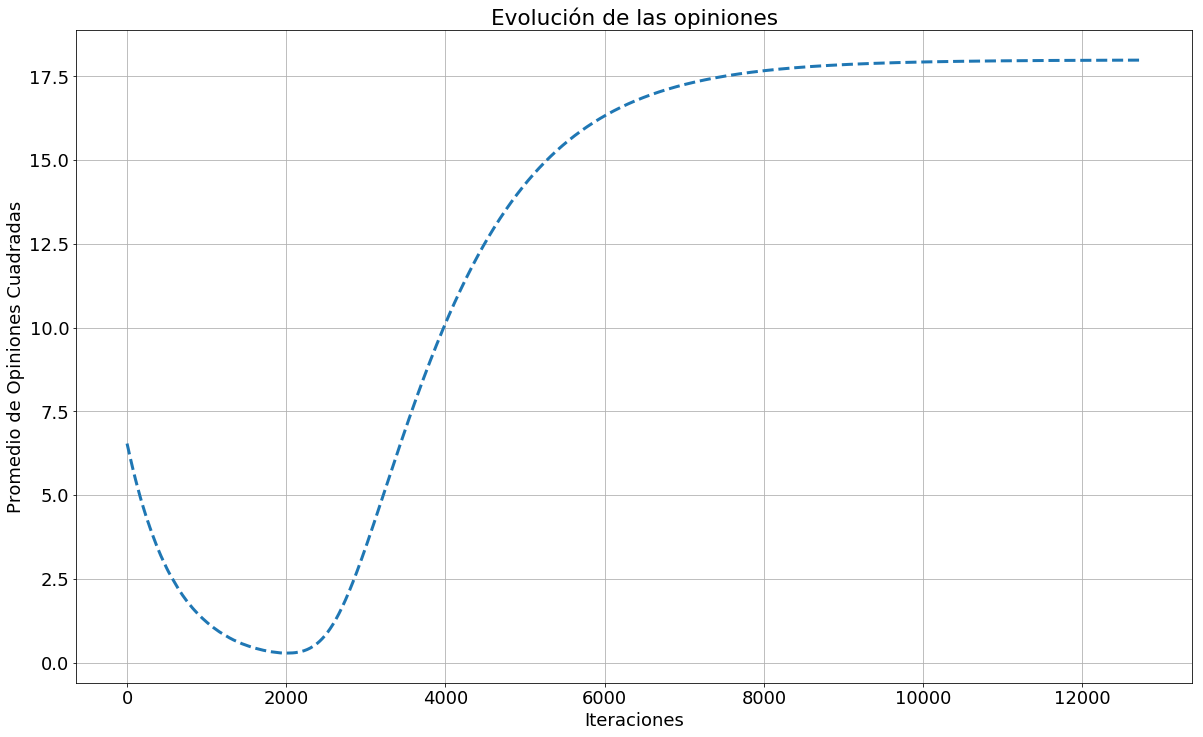

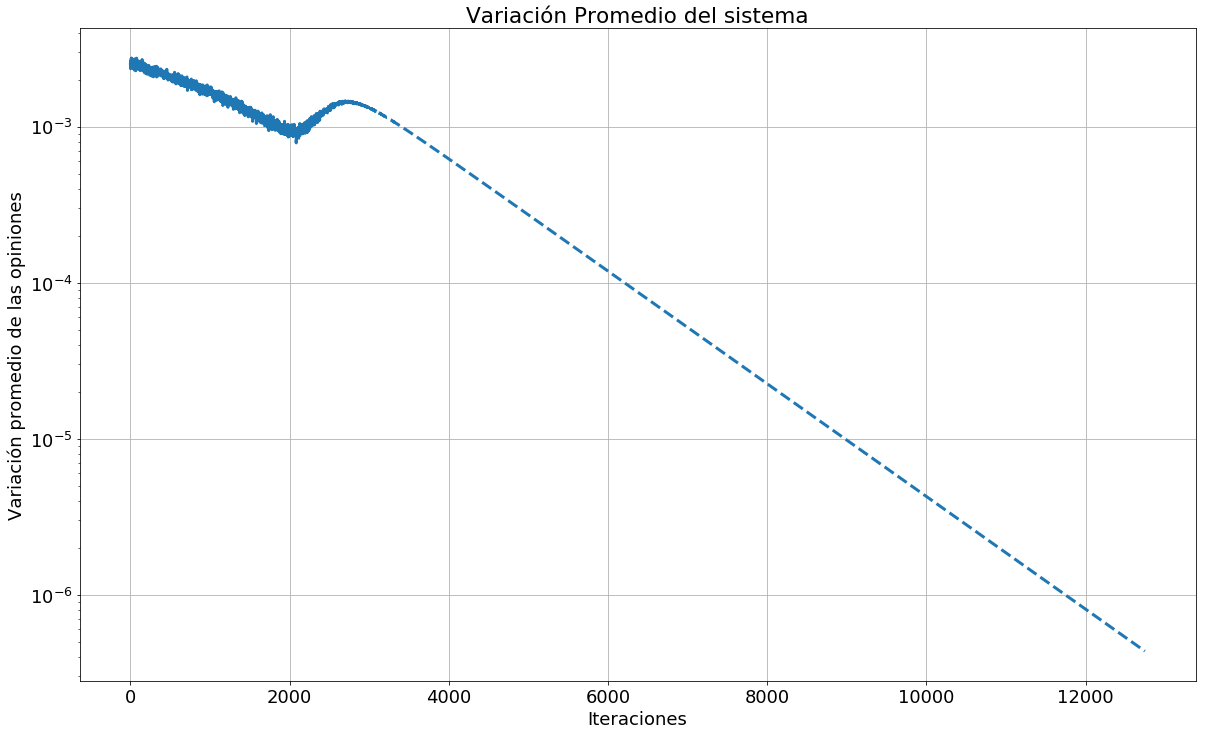

Esto tardó 4.346744775772095 segundos


In [23]:
t0 = time.time()

# En esta celda lo que voy a hacer es mirar los datos que obtuve del programa
# Donde alfa y Delta son las variables. Quiero ver que no haya tocado nada
# raro en el programa y que siga funcionando bien.

#--------------------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./Grafico Baumann")]

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[0] es el nombre de la carpeta

for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Datos Corte
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]

#--------------------------------------------------------------------------------------------

# Levanto los datos del archivo original y separo los datos en tres listas.
# Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

Datos = ldata("{}/{}".format(Archivos_Datos[0],Archivos_Datos[1]))

Ady = Datos[1][1:len(Datos[1])] # Lista con elementos de la matriz de Adyacencia
Ady = [int(x) for x in Ady]

Sup = Datos[3][1:len(Datos[3])] # Lista con elementos de la matriz de Superposición
Sup = [float(x) for x in Sup]

# Lista con elementos de los vectores de opinión. Al final sí había una forma compacta de hacer esto.
# Si la matriz de Adyacencia evoluciona en el tiempo, va a haber que ver de hacer cambios acá.
Opi = [[float(x) for x in fila[1:len(fila)]] for fila in Datos[5:len(Datos)]]

# Mis listas ya se arman correctamente, tengo separados sin dramas los valores de mis tres matrices.

#--------------------------------------------------------------------------------------------

# Hagamos un gráfico de estos datos
# La idea es hacer una sumatoria del valor cuadrado de las opiniones de cada uno.
# En otra celda empezaré a ver de hacer un gráfico que registre la trayectoria de la opinión de los agentes.

X = np.arange(0,len(Opi))
T = 2 # Este es el número de tópicos
POC = {} # POC significa Promedio Opiniones Cuadradas.
for j in range(T):
    # Obtengo los valores cuadrados de todos mis tópicos
    POC[j] = []
    for i in range(len(Opi)):
        # TS es Tópicos Separados. Esta lista va a ir tomando todas las opiniones de un cierto tópico en una iteración
        TS = [t**2 for t in Opi[i][j:len(Opi[i]):T]]
        # Ahora los sumo y los agrego a mis vectores Y
        POC[j].append(np.sum(TS)/len(TS))


# El vector X con el número de iteraciones, así como el diccionario que guarda las opiniones de cada tópico por
# separado funcionan correctamente. Ahora puedo cambiar el número de tópicos de mi sistema sin dramas.

# -------------------------------------------------------------------------------------------

# Hay que ver la forma de graficar esto correctamente, sin que estalle en términos de cantidad de
# cosas graficadas, y que permita entenderse


YT = np.zeros(len(Opi))
for j in range(T):
    YT += np.array(POC[j])

plt.figure(figsize=(20,12))
plt.plot(X,YT, "--", linewidth = 3)
plt.rcParams.update({'font.size': 18})
plt.xlabel("Iteraciones")
plt.ylabel("Promedio de Opiniones Cuadradas")
plt.title("Evolución de las opiniones")
plt.grid()
plt.show()

#-------------------------------------------------------------------------------------------------

# Acabo de caer en la cuenta que aunque no guarde los datos de las variaciones,
# puedo calcularlas, total tengo todos los datos de opiniones del sistema. El renglón de
# Var define la lista por comprensión.

Var = [math.sqrt(np.sum(np.array([((x2-x1)**2)/len(Opi[i]) for x1,x2 in zip (Opi[i],Opi[i+1])]))) for i in range(len(Opi)-1)]
X = np.arange(0,len(Var))

plt.figure(figsize=(20,12))
plt.semilogy(X,Var, "--",label="N={},K={},T={}".format(N,K,T) ,linewidth = 3)
plt.rcParams.update({'font.size': 18})
plt.xlabel("Iteraciones")
plt.ylabel("Variación promedio de las opiniones")
plt.title("Variación Promedio del sistema")
plt.grid()
plt.show()

# El programa sigue funcionando bárbaro, lo cual es buenísimo. Corta en el momento
# adecuado y el comportamiento es razonbale.



Tiempo()